In [390]:
using Plots
using StatsBase
using Statistics
pyplot()

include("ARMA_Generator.jl")
include("wiener_filter_scalar.jl")

wiener_filter_NT (generic function with 1 method)

In [391]:
# Graph stuff
Nex = 1000;
Theta = 2pi*(0:Nex)/Nex;
Z = map(th -> exp(im*th),Theta);

So far it was tested with 

`
steps = 10^4
discard = 10^3
l = [1, -5/4, 3/8]
pred = ARMA_gen(l, steps = steps)
w = [1, -5/3, 4, -20/3];
sig = ARMA_gen([],w, steps = steps);
`

And with 

`
steps = 10^4
discard = 10^3
Zeros = [-.2im .2im .8]
Poles = [.5im -.5im .6]
pred = ARMA_gen(Zeros = Zeros, Poles = Poles, steps = steps, discard = discard)
Zeros = [.8]
Poles = [.33im -.33im .2]
sig = ARMA_gen(Zeros = Zeros, Poles = Poles, steps = steps, discard = discard)
`

Then with 

`
steps = 10^4
discard = 10^3
p, q = 5 , 6
Zeros_pred = 1 .- rand(q)*2
Poles_pred = 1 .- rand(p)*2
pred = ARMA_gen(Zeros = Zeros_pred, Poles = Poles_pred, steps = steps, discard = discard)
p, q = 3 , 6
Zeros_sig = 1 .- rand(q)*2
Poles_sig = 1 .- rand(p)*2
sig = ARMA_gen(Zeros = Zeros_sig, Poles = Poles_sig, steps = steps, discard = discard)
`

Here we build WSS processes to test the WF.

In [392]:
steps = 10^5
discard = 10^3
p, q = 5 , 3
Zeros_pred = 1 .- rand(q)*2
Poles_pred = 1 .- rand(p)*2
pred = ARMA_gen(Zeros = Zeros_pred, Poles = Poles_pred, steps = steps, discard = discard)

P_pred = prod([Poly([1]); [Poly([1,-z]) for z in Poles_pred]])
Q_pred = prod([Poly([1]); [Poly([1,-z]) for z in Zeros_pred]])
tranfer_fun(z) = Q_pred(z^(-1))/P_pred(z^(-1))
z_spect_pred_ana(z) = abs(tranfer_fun(z))^2
z_spect_pred_num = z_spect(pred,20, win = "Par");

# plot(Theta, [z_spect_pred_ana.(Z) real.(z_spect_pred_num.(Z))])

p, q = 2 , 6
Zeros_sig = 1 .- rand(q)*2
Poles_sig = 1 .- rand(p)*2
sig = ARMA_gen(Zeros = Zeros_sig, Poles = Poles_sig, steps = steps, discard = discard)

P_sig = prod([Poly([1]); [Poly([1,-z]) for z in Poles_sig]])
Q_sig = prod([Poly([1]); [Poly([1,-z]) for z in Zeros_sig]])

tranfer_fun(z) = Q_sig(z^(-1))/P_sig(z^(-1))
z_spect_sig_ana(z) = abs(tranfer_fun(z))^2
z_spect_sig_num = z_spect(sig,35, win = "Par");

# plot(Theta, [z_spect_sig_ana.(Z) real.(z_spect_sig_num.(Z))])

In [393]:
function wiener_filter_NT(pred,sig,M)
    # pred are the predictors
    # sig is the sequence to be approximated
    # M is the degree of the approximating Laurent polynomials

    # Approximate autocorr and crosscor (Laurent degree M)
    R_pred    = autocov(pred,0:M)
    R_predsig = crosscov(pred,sig, -M:M)

    #     Smoothing
    LL = Int(floor(M/2))
    lam1 = 1 .- 6*((0:LL)/M).^2 .+ 6*((0:LL)/M).^3
    lam2 = 2*(1 .- (LL+1:M)/M).^3
    lam = [lam1; lam2]

    R_pred = R_pred.*lam
    R_predsig = R_predsig.*[reverse(lam[2:M+1]); lam]

    l = Scalar_CKMS_c(R_pred);
    
#   Auxilaries
    N = 100
    Nh = Int(floor(N/2))
    Z_N = exp.(2*pi*im/N*(0:N-1))
    Theta_N = 2*pi/N*(0:N-1)
    
#   The Players is the Wiener-Hopf solution
    z_spect_minus_num(z) = sum([l[i+1]z^(-i) for i = 0:M])
    z_spect_plus_num(z) = z_spect_minus_num(z)'
    z_spect_sigpred(z) = sum([R_predsig[i]*z^(M+1 - i) for i = 1: 2*M + 1])


    S_plus_invS_sigpred_fft = fft(z_spect_sigpred.(Z_N)./
                                  z_spect_plus_num.(Z_N))/N
    
    S_plus_invS_sigpred_coef = [S_plus_invS_sigpred_fft[1:Nh]; zeros(N-Nh)]
    z_spect_invS_sigpred_plus = ifft(S_plus_invS_sigpred_coef)*N
    
    H =  fft(z_spect_invS_sigpred_plus./
             z_spect_minus_num.(Z_N))/N
    h_TD = H[1:M]
end

wiener_filter_NT (generic function with 1 method)

In [394]:
h = wiener_filter(pred,sig, 2)

h_TD = wiener_filter_NT(pred,sig, 2)

h , h_TD

([-0.000221373, 0.00134218], Complex{Float64}[0.00148001+2.14652e-20im, -0.00103361-1.08603e-19im])

In [395]:
norm(h - h_TD)

0.0029221726525020643

In [396]:
sig_hat = ARMA_gen([],h,steps = steps - discard, discard = discard, e = pred);

z_spect_sig_hat_num = z_spect(sig_hat,50, win = "Par");

In [397]:
sig_hat_TD = ARMA_gen([],h,steps = steps - discard, discard = discard, e = pred);

z_spect_sig_hat_TD_num = z_spect(sig_hat_TD,50, win = "Par");

mean:     -2.028652989023294e-6
Variance: 1.62878774170518e-5

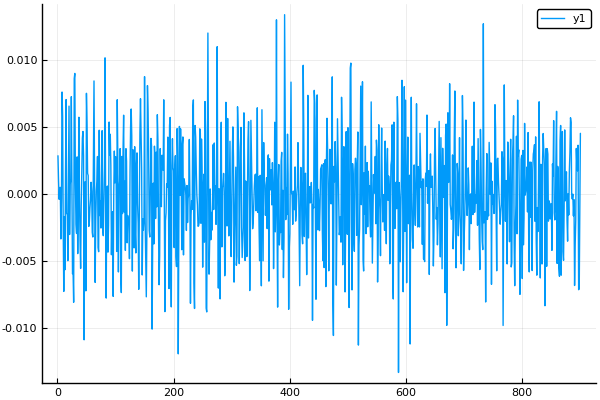

In [398]:
lags = 0:899
sig_trunc = sig[1:steps - discard]
pred_trunc = pred[1:steps - discard]
C = crosscov(pred_trunc,sig_trunc .- sig_hat,lags);
print("mean:     ", mean(C),"\nVariance: ", std(C)^2)
plot(C)

mean:     -2.028652989023294e-6
Variance: 1.62878774170518e-5

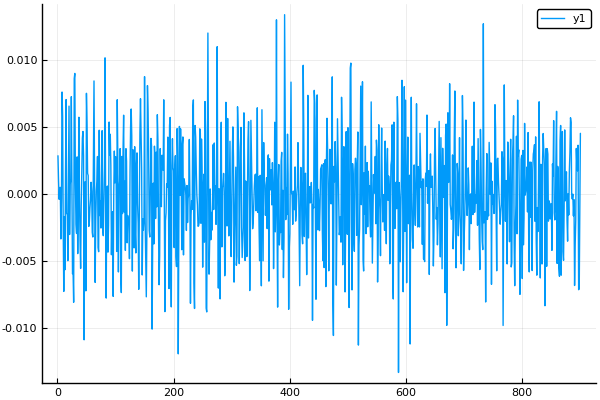

In [399]:
C_TD = crosscov(pred_trunc,sig_trunc .- sig_hat_TD,lags);
print("mean:     ", mean(C_TD),"\nVariance: ", std(C_TD)^2)
plot(C_TD)

In [400]:
# z-spect of errors
errors = sig_trunc .- sig_hat;
z_spect_errors = z_spect(errors,30, win = "Par");

# Wiener filter transfer function
HH(z) = Poly(h)(z^(-1));

In [401]:
# z-spect of errors
errors_TD = sig_trunc .- sig_hat_TD;
z_spect_errors_TD = z_spect(errors_TD,30, win = "Par");

# Wiener filter transfer function
H_TD(z) = Poly(h_TD)(z^(-1));

In [402]:
# cross z-spect sig pred
L_cc_sigpred = 50
A = crosscov(sig_trunc,pred_trunc,0:L_cc_sigpred);
A[1] = .5*A[1]
lam = .5*(1 .+ cos.(pi/L_cc_sigpred*(0:L_cc_sigpred)))
# lam = ones(L_cc_sigpred +1)
z_spect_cross(z) = sum([lam[i+1]*(A[i+1]'*z^(-i) +
                        A[i+1]*z^(i)) for i = 0 : L_cc_sigpred])

z_spect_sig_wf(z) = z_spect_errors(z) + HH(z)*conj(z_spect_cross(z)) +
                    conj(HH(z))*z_spect_cross(z) - HH(z)*z_spect_pred_num(z)*conj(HH(z));

Z_errs = z_spect_errors.(Z);
Z_cross1 = map(z -> HH(z)*conj(z_spect_cross(z)),Z);
Z_cross2 = map(z -> conj(HH(z))*z_spect_cross(z),Z);
Z_sig_hat = map(z -> HH(z)*z_spect_pred_num(z)*conj(HH(z)),Z);
# plot(Theta, real.([Z_errs Z_cross1 Z_cross2 Z_sig_hat]))

In [403]:
# cross z-spect sig pred
z_spect_sig_wf_TD(z) = z_spect_errors_TD(z) + H_TD(z)*conj(z_spect_cross(z)) +
                    conj(H_TD(z))*z_spect_cross(z) - H_TD(z)*z_spect_pred_num(z)*conj(H_TD(z));

Z_errs_TD = z_spect_errors_TD.(Z);
Z_cross1_TD = map(z -> H_TD(z)*conj(z_spect_cross(z)),Z);
Z_cross2_TD = map(z -> conj(H_TD(z))*z_spect_cross(z),Z);
Z_sig_hat_TD = map(z -> H_TD(z)*z_spect_pred_num(z)*conj(H_TD(z)),Z);
# plot(Theta, real.([Z_errs Z_cross1 Z_cross2 Z_sig_hat]))

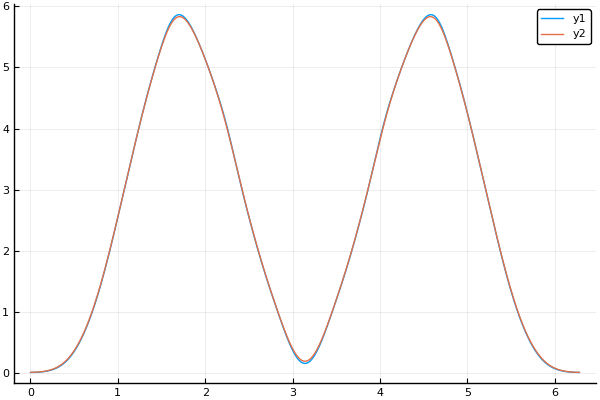

In [404]:
plot(Theta, [real.(z_spect_sig_num.(Z)) real.(z_spect_sig_wf.(Z))])

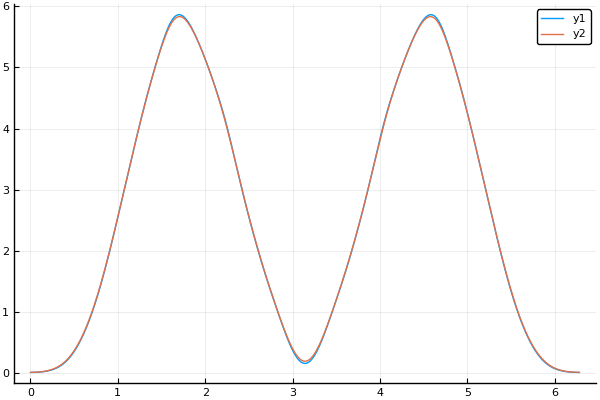

In [405]:
plot(Theta, [real.(z_spect_sig_num.(Z)) real.(z_spect_sig_wf_TD.(Z))])

In [406]:
print("Zeros_pred: ",Zeros_pred,"\n")
print("Poles_pred: ",Poles_pred,"\n")
print("Zeros_sig: ",Zeros_sig,"\n")
print("Poles_sig: ",Poles_sig,"\n")

Zeros_pred: [0.742263, -0.179249, -0.00321225]
Poles_pred: [0.407266, 0.679348, -0.138221, -0.450728, 0.662504]
Zeros_sig: [0.813425, 0.301409, 0.996235, -0.328301, -0.954645, -0.542078]
Poles_sig: [-0.74126, 0.367672]
